In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Load the data
training_data = pd.read_csv('Data/training.csv')
drop_columns = ['Unnamed: 0', 'pad_id', 'standardized_operator_name', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage', 'number_of_stages', 'frac_type']
training_data.drop(columns=drop_columns, inplace=True)
training_data.drop_duplicates(inplace=True)
training_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convert any "Undefined" or "Unknown" values to NaN
training_data.replace('Undefined', np.nan, inplace=True)
training_data.replace('Unknown', np.nan, inplace=True)

# Before imputing, keep track of rows with missing values for 'OilPeakRate' to remove them later
rows_with_missing_values = training_data[training_data['OilPeakRate'].isnull()].index.to_list()

In [3]:
# Label categorical variables as such
categorical_columns = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship']

# Get numeric columns
numeric_columns = training_data.select_dtypes(include=np.number).columns.to_list()

# Impute categorical variables with the most frequent value
imputer = SimpleImputer(strategy='constant', fill_value='missing')
training_data[categorical_columns] = imputer.fit_transform(training_data[categorical_columns])

# Impute numerical variables with the KNN algorithm
imputer = KNNImputer(n_neighbors=10)
training_data[numeric_columns] = imputer.fit_transform(training_data[numeric_columns])

# Encode categorical variables using OrdinalEncoder
encoder = OrdinalEncoder()
training_data[categorical_columns] = encoder.fit_transform(training_data[categorical_columns])

In [4]:
# drop rows with missing values for 'OilPeakRate'
training_data.drop(index=rows_with_missing_values, inplace=True)

# Remove outliers in 'OilPeakRate' based on the 1.5*IQR rule
Q1 = training_data['OilPeakRate'].quantile(0.25)
Q3 = training_data['OilPeakRate'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)
upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR
training_data = training_data[(training_data['OilPeakRate'] < upper_bound) & (training_data['OilPeakRate'] > lower_bound)]

Q1:  107.91815165000001
Q3:  298.07321790000003
IQR:  190.15506625


In [5]:
# Create a 'well_length' column
# The formula for well length is sqrt(|surface_x - bh_x|^2 + |surface_y - bh_y|^2 + true_vertical_depth^2)
# training_data['well_length'] = np.sqrt((training_data['surface_x'] - training_data['bh_x'])**2 + (training_data['surface_y'] - training_data['bh_y'])**2 + training_data['true_vertical_depth']**2)

In [6]:
# Create a 'well_skew' column
# The formula for well skew is sqrt(|surface_x - bh_x|^2 + |surface_y - bh_y|^2)
training_data['well_skew'] = np.sqrt((training_data['surface_x'] - training_data['bh_x'])**2 + (training_data['surface_y'] - training_data['bh_y'])**2)

In [7]:
# Create a 'lateral_length' column
# The formula for lateral length is sqrt(|horizontal_toe_x - bh_x|^2 + |horizontal_toe_y - bh_y|^2)
training_data['lateral_length'] = np.sqrt((training_data['horizontal_toe_x'] - training_data['bh_x'])**2 + (training_data['horizontal_toe_y'] - training_data['bh_y'])**2)

In [8]:
RANDOM_STATE = 100

# Split the data into training and test sets
drop_training_columns = ['OilPeakRate']
X = training_data.drop(columns=drop_training_columns, axis=1)
y = training_data['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

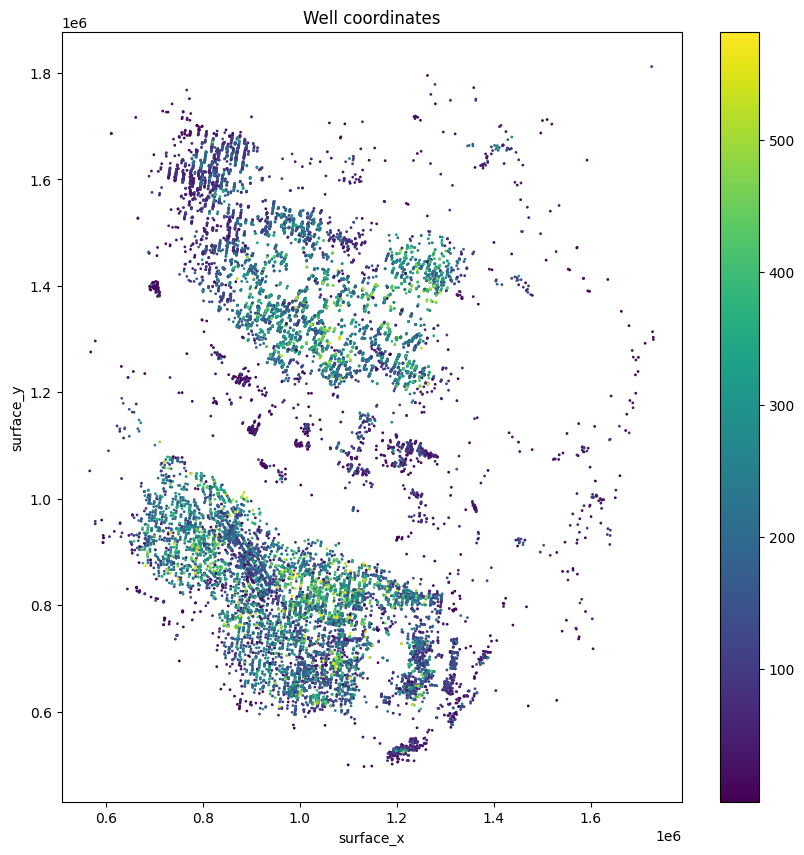

In [9]:
# Plot the well coordinates "surface_x" and "surface_y"
plt.figure(figsize=(10, 10))
plt.scatter(training_data['horizontal_toe_x'], training_data['horizontal_toe_y'], c=training_data['OilPeakRate'], s=1)
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()

Test set RMSE: 99.45
Training set RMSE: 91.76


/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


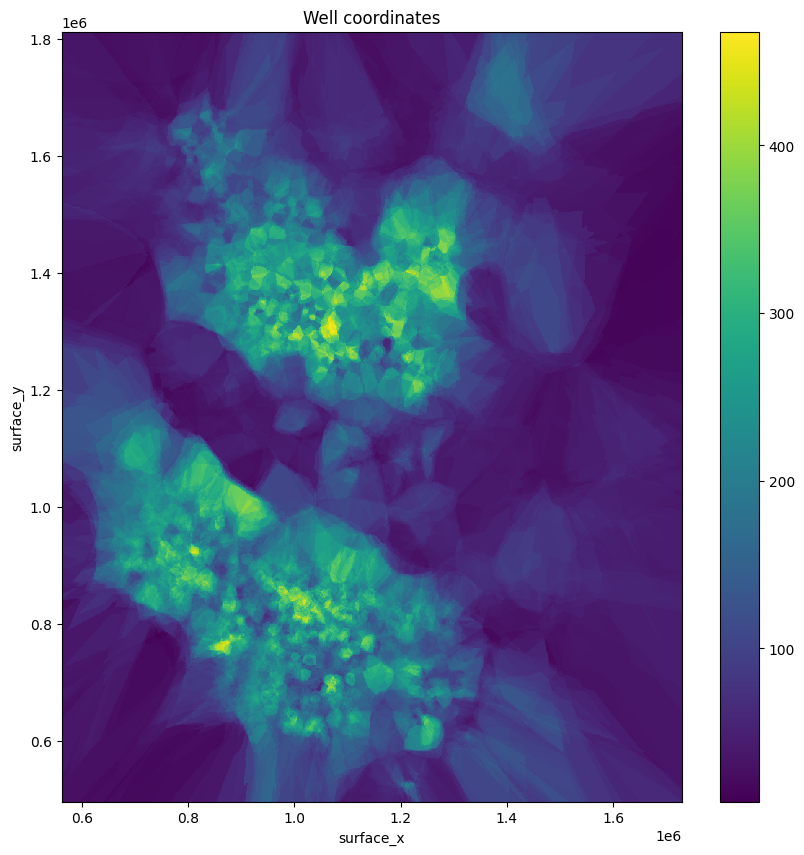

In [10]:
# Instantiate the KNN model for just surface_x and surface_y
X_s = X[['surface_x', 'surface_y']]
y_s = y

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=RANDOM_STATE)

# Instantiate the KNeighborsRegressor for surface_x and surface_y
model = KNeighborsRegressor(n_neighbors=15)
model.fit(X_train_s, y_train_s)

# Predict the test set labels
y_pred = model.predict(X_test_s)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train_s)
rmse_train = np.sqrt(mean_squared_error(y_train_s, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

# Plot the mesh of the predicted values
# Create a mesh of values to plot
xx = np.linspace(X_s['surface_x'].min(), X_s['surface_x'].max(), 1000)
yy = np.linspace(X_s['surface_y'].min(), X_s['surface_y'].max(), 1000)
xx, yy = np.meshgrid(xx, yy)
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the values of the mesh
y_pred = model.predict(X_grid)

# Plot the predicted values
plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, y_pred.reshape(xx.shape))
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()

# Use the model to create a new column in the training data
training_data['KNN_surface_OilPeakRate'] = model.predict(X_s)

In [11]:
# Make new training and test sets with the new columns
drop_training_columns = ['OilPeakRate']
X = training_data.drop(columns=drop_training_columns, axis=1)
y = training_data['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Change the data type of the categorical columns to 'category'
X_train[categorical_columns] = X_train[categorical_columns].astype('category')

In [12]:
# Wrap the HistGradientBoostingRegressor in an AdaBoostRegressor
model = AdaBoostRegressor(estimator=HistGradientBoostingRegressor(max_iter=1000, l2_regularization=0.1),
                          n_estimators=15, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 78.92
Training set RMSE: 21.20


Test set RMSE: 92.62
Training set RMSE: 83.42


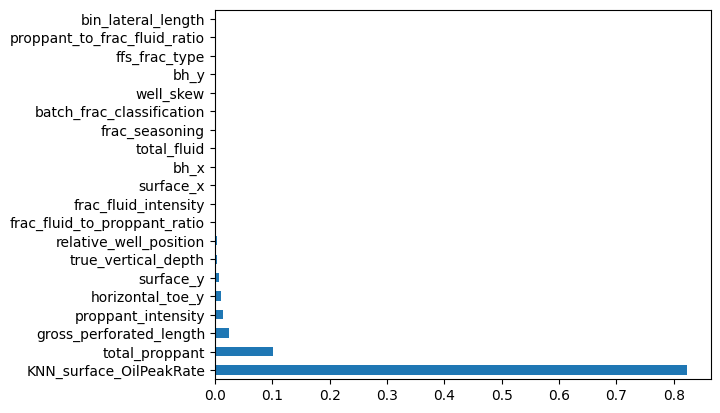

In [13]:
# # Instantiate the DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

# Show feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(20).plot(kind='barh')
plt.show()

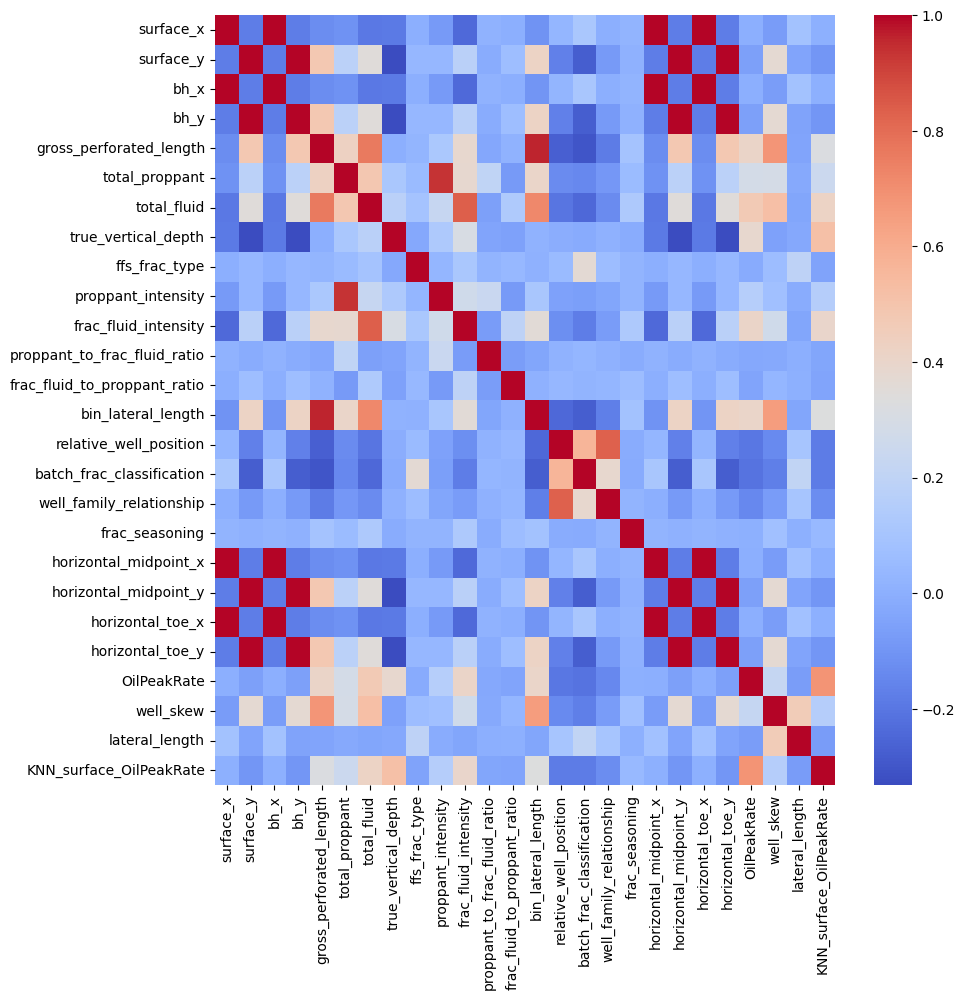

In [14]:
# Plot a correlation heatmap
corr = training_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='coolwarm')
plt.show()